# Notebook to test SetFit performance

# Setup and data cleaning

## Check if CUDA is available and use it if it is

In [2]:
import os
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss, BatchHardTripletLossDistanceFunction

import pandas as pd
import numpy as np

import logging
import warnings

# Disable some logs because there were too many messages during the tests
# logging.disable(logging.INFO)
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

from datasets import disable_progress_bar
disable_progress_bar() # Disable the "Map" progress bar during the tests
    
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Load and clean the dataset

This dataset is not on the GitHub repository.
It's composed of work experienced fetched from LinkedIn and labelled between 0 and 4 (0 if it's not related to AI and 4 if it is)

In [3]:
dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset = subset[['text','label']]
subset_label_transform = subset.copy()

subset_label_transform['label'] = np.where((subset_label_transform["label"] < 3) | (subset_label_transform["label"].isna()), 0, 1)
subset_label_transform

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


## Split the dataset in two subsets : the training and test sets

In [4]:
from utility import split_dataset
train_set, test_set = split_dataset(subset_label_transform, 0.2)

## Repeat this process with diffent ways of cleaning the data

Here instead of considering Nan, 0, 1 and 2 as not being an AI experience and 3 and 4 as being one, we consider :

- not AI = 0 and 1 and AI = 3 and 4 (we drop the examples with the label NaN or 2)
- not AI = 0 and AI = 4 (we drop the examples with the label NaN, 1, 2 or 3)

In [5]:
subset_label_transform_likely_labels = subset.copy()
subset_label_transform_likely_labels.replace({2: np.nan}, inplace=True)
subset_label_transform_likely_labels.dropna(inplace=True)
subset_label_transform_likely_labels['label'] = np.where((subset_label_transform_likely_labels["label"] < 3), 0, 1)

subset_label_transform_sure_labels = subset.copy()
subset_label_transform_sure_labels.replace({1: np.nan, 2: np.nan, 3: np.nan}, inplace=True)
subset_label_transform_sure_labels.dropna(inplace=True)
subset_label_transform_sure_labels['label'] = np.where((subset_label_transform_sure_labels["label"] == 0), 0, 1)

# We keep the full test set
train_set_likely_labels, _ = split_dataset(subset_label_transform_likely_labels, 0.2) 
train_set_sure_labels, _ = split_dataset(subset_label_transform_sure_labels, 0.2)

## Run tests

In [6]:
from utility import save_to_json
from fewShotBenchmark import n_shot_tests, input_length_tests, distance_tests, loss_tests, language_tests, model_tests, num_epochs_tests, constant_params_tests, data_augmentation_tests, frozen_ratio_tests
from models import protonet_f1_score, setfit_f1_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### N-shots

By default SetFit uses the oversampling strategy and the Cosine Similarity loss. For instance if we have 8 positive and 8 negative examples then we have:

|   | Y | Y | Y | Y | Y | Y | Y | Y | N | N | N | N | N | N | N | N |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Y | + | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   |   | + | - | - | - | - | - | - | - | - |
| N |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + |

- P = 2 * (8 + 7 + 6 + 5 + 4 + 3 + 2 + 1) 	= 72
- N = 8 * 8 = 64 -> + 8 duplications 		= 72
- Total = 72 + 72 = 144

In [ ]:
params = {
    "n_shot": [2, 4, 6, 8, 10, 20, 40, 60, 100],
    "n_iter": 2,
    "n_max_iter_per_shot": 2,
    "model": "sentence-transformers/paraphrase-mpnet-base-v2",
    "loss": BatchAllTripletLoss
}

results, run_times = n_shot_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/n_shot')

In [ ]:
params = {
    "n_shot": [2, 4, 6, 10],
    "n_iter": 2,
    "n_max_iter_per_shot": 2,
    "model": "sentence-transformers/paraphrase-mpnet-base-v2",
    "loss": "Cosine"
}

results, run_times = n_shot_tests(params, train_set, test_set.head(1000), few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/n_shot')

### Input length

In [7]:
params = {
    "input_length_range": [[0,5],[5,25],[25,50],[50,100],[100,200],[200,350]],
    # [[6,10],[10,15],[15,20],[20,30], [6,15], [15,30], [6,20], [10,30], [6,30]],
    # [[0,5],[5,10], [10,50], [50,100],[100,200],[200,350]],
    # [[0,9],[1,9],[2,9],[3,9],[4,9],[5,9],[6,9],[7,9],[8,9],[9,9]],
    # [[0,9],[9,100],[9,350],[100,350],[0,350]],
	# [[8,50],[8,100],[8,150],[8,200],[8,250],[8,300],[8,350]],
	# [[7,350],[8,350],[9,350],[10,350]],
    # [[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10]],
    # [[0,5],[0,10],[0,100],[6,100],[200,350]],
	"n_shot": 8,
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = input_length_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/input_length')

Step: 1 / 12 Estimated remaining time: ?


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 2 / 12 Estimated remaining time: 3 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 3 / 12 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 4 / 12 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 5 / 12 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 6 / 12 Estimated remaining time: 4 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 7 / 12 Estimated remaining time: 3 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 8 / 12 Estimated remaining time: 3 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 9 / 12 Estimated remaining time: 2 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 10 / 12 Estimated remaining time: 2 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 11 / 12 Estimated remaining time: 1 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 12 / 12 Estimated remaining time: 36 s


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


In [8]:
params = {
    "input_length_range": [[0,5],[5,25],[25,50],[50,100],[100,200],[200,350]],
	"n_shot": 8,
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": "Cosine"
}

results, run_times = input_length_tests(params, train_set, test_set, few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/input_length')

Step: 1 / 12 Estimated remaining time: ?


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


[0,5] failed Invalid key: 1 is out of bounds for size 1
Step: 2 / 12 Estimated remaining time: 37 s


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 3 / 12 Estimated remaining time: 11 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 4 / 12 Estimated remaining time: 15 m


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


### Distance

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"distance": {
		"Cosine":BatchHardTripletLossDistanceFunction.cosine_distance,
		"Euclidian": BatchHardTripletLossDistanceFunction.eucledian_distance, # it's really "eucledian" and not "euclidian" in the module sentence_transformers
	},
	"loss": BatchAllTripletLoss,
}


results, run_times = distance_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/distance')

### Loss (pair-wise or Triplet)

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": {"Pair-wise":CosineSimilarityLoss, "Triplet":BatchAllTripletLoss}
}

results, run_times = loss_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/loss')

### Language

In [ ]:
params = {
	"n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = language_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/language')

In [ ]:
params = {
    "n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": "Cosine"
}

results, run_times = language_tests(params, train_set, test_set, few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/language')

### Embedding Model

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 2,
	"loss": BatchAllTripletLoss,
	"model": {
		"instructor-large":"hkunlp/instructor-large",
		"GIST-small-Embedding-v0":"avsolatorio/GIST-small-Embedding-v0",
		"gte-tiny":"TaylorAI/gte-tiny",
		"all-mpnet-base-v2-table":"deepset/all-mpnet-base-v2-table",
  		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		"all-mpnet-base-v2":"sentence-transformers/all-mpnet-base-v2",
	}
}
results, run_times = model_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/model')

In [ ]:
params = {
    "n_shot": 8,
	"n_iter": 2,
	"loss": "Cosine",
    "model": {
        "instructor-large":"hkunlp/instructor-large",
		"GIST-small-Embedding-v0":"avsolatorio/GIST-small-Embedding-v0",
		"gte-tiny":"TaylorAI/gte-tiny",
		"all-mpnet-base-v2-table":"deepset/all-mpnet-base-v2-table",
  		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		"all-mpnet-base-v2":"sentence-transformers/all-mpnet-base-v2",
    }
}

results, run_times = model_tests(params, train_set, test_set, few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/model')

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 1 / 2 Estimated remaining time: ?
Step: 2 / 2 Estimated remaining time: 2 m


### Number of epochs

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 2,
	"loss": BatchAllTripletLoss,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"num_epochs": [(8,1),(8,2),(8,4),(8,8),(8,10),(8,20),(8,30),(8,40)], 
	# [(1,1),(2,1),(4,1),(8,1),(16,1),(32,1),(64,1)], 
	# [(1,1),(1,2),(1,4),(1,8),(1,12),(1,16),(1,20),(1,25),(1,30)],
}

results, run_times = num_epochs_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/num_epochs')

In [ ]:
params = {
    "n_shot": 8,
	"n_iter": 2,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": "Cosine",
    "num_epochs": [(1,0),(2,0),(4,0),(8,0),(16,0),(32,0)], # There is no classification head 
}

results, run_times = num_epochs_tests(params, train_set, test_set, few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/num_epochs')

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 1 / 60 Estimated remaining time: ?


### Data sampling

Run multiple tests with different training sets but the same parameters

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 2,
	"loss": BatchAllTripletLoss,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"num_epochs":(1,16),
	"input_length_range":[0,9],
}

results, run_times = constant_params_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/setfit/data_sampling')

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 2,
	"loss": BatchAllTripletLoss,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"num_epochs":(1,16),
	"input_length_range":[0,9],
    "ratio_frozen_weights": 0.5
}

results, run_times = constant_params_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/data_sampling')

Step: 1 / 2
0 failed setfit_f1_score() missing 1 required positional argument: 'pipe'
Step: 2 / 2
1 failed setfit_f1_score() missing 1 required positional argument: 'pipe'


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

### Data Augmentation

For now we only use a back translation technique and synonym replacement, but we could try other ones

In [ ]:
params = {
    "n_shot": 8,
    "n_iter": 2,
    "loss": BatchAllTripletLoss,
    "model": "sentence-transformers/paraphrase-mpnet-base-v2",
    "data_augmentation_ratio": 1.3, # + 30 %
    "data_augmentation_strategy":["none","swapping_inter", "back_translation", "synonym_replacement", "crossover"],
    "strategy_params": {
        "n_points_crossover": 2,
        "modification_rate": 0.5,
    }
}

results, run_times = data_augmentation_tests(params, train_set, test_set, few_shot_model_f1_function=setfit_f1_score)
save_to_json(results, run_times, params,  r'../results/setfit/data_augmentation')

### Frozen weights ratio

In [ ]:
params = {
    "n_shot": 8,
	"n_iter": 1,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": "Cosine",
    "ratio_frozen_weights": [0.1,0.3,0.5,0.7,0.9]
}

results, run_times = frozen_ratio_tests(params, train_set, test_set, few_shot_model_f1_function=protonet_f1_score)

save_to_json(results, run_times, params,  r'../results/protonet/frozen_ratio')

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Step: 1 / 5 Estimated remaining time: ?
Step: 2 / 5 Estimated remaining time: 12 m
Step: 3 / 5 Estimated remaining time: 11 m
Step: 4 / 5 Estimated remaining time: 8 m
Step: 5 / 5 Estimated remaining time: 4 m


### Dataset label selection

Only select labels 0,1,3,4 and then 0,1

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 50,
	"loss": CosineSimilarityLoss,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
}

tested_training_sets = {
	"all_labels": train_set,
	"likely_labels":train_set_likely_labels,
	"sure_labels":train_set_sure_labels,
}

results = {}
run_times = {}
progress = 0
progress_end = len(tested_training_sets)

for training_set_key, training_set_data in tested_training_sets.items():
	print("Test: ", progress,"/",progress_end)
	temp_results, temp_run_times = constant_params_tests(params, training_set_data, test_set)
	results[training_set_key] = temp_results["all"]
	run_times[training_set_key] = temp_run_times["all"]

params["training_set"] = list(tested_training_sets.keys())
save_to_json(results, run_times, params,  r'../results/setfit/training_set_labels_restriction')

## Graphs

In [9]:
from utility import load_all_results_data, create_boxplot, create_bar_plot, load_latest_results_data

### Plot latest graphs

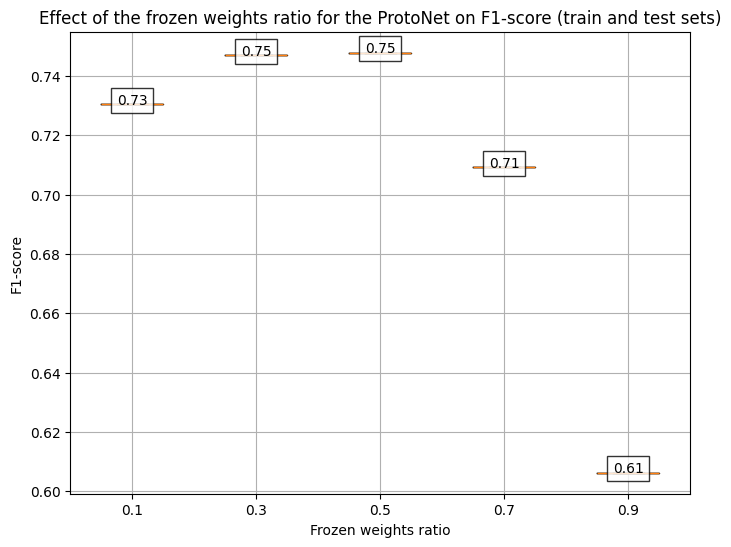

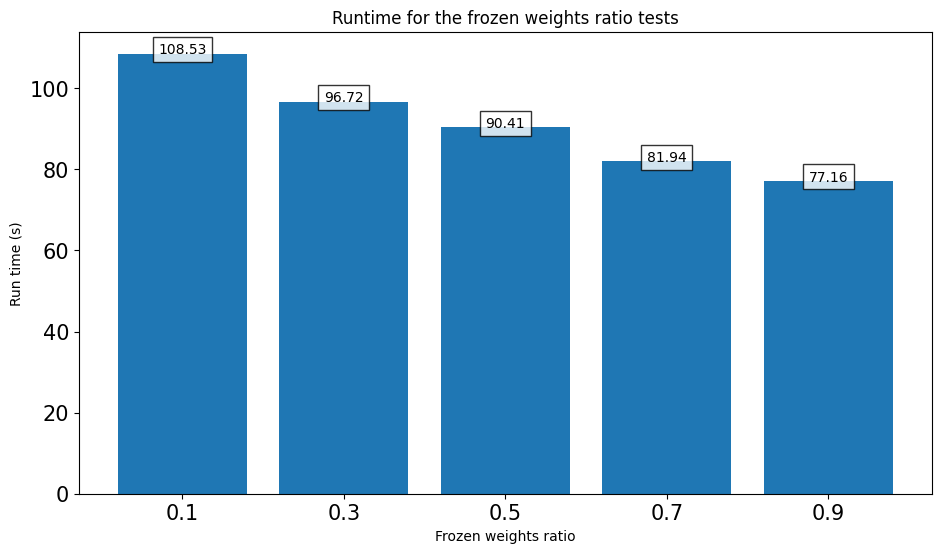

In [10]:
# results, run_times, _ = load_latest_results_data(r'../results/setfit/n_shot')
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# # create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/input_length')
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only) (8 shots)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/distance')
# create_boxplot(results, 'Effect of the distance on F1-score', 'Distance', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the distance tests', 'Distance', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/loss')
# create_boxplot(results, 'Effect of the loss on F1-score', 'Loss', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the loss tests', 'Loss', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/language')
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/model')
# create_boxplot(results, 'Effect of the Sentence Transformer model on F1-score', 'Model', 'F1-score', vertical_xticks=True)
# create_bar_plot(run_times, 'Runtime for the Sentence Transformer model tests', 'Model', 'Run time (s)', vertical_xticks=True)

# results, run_times, _ = load_latest_results_data(r'../results/setfit/num_epochs')
# create_boxplot(results, 'Effect of the number of epochs on F1-score', 'Number of epochs', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the number of epochs tests', 'Number of epochs', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/head_learning_rate')
# create_boxplot(results, 'Effect of the head learning rate on F1-score', 'Head learning rate', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the head learning rate tests', 'Head learning rate', 'Run time (s)')

# results, run_times, params = load_latest_results_data(r'../results/setfit/data_sampling')
# create_boxplot(results, f"F1-score with the same params with {params['n_iter']} different support sets", str(params), 'F1-score')
# create_bar_plot(run_times, 'Runtime for the same params', str(params), 'Run time (s)')

# results, run_times, params = load_latest_results_data(r'../results/setfit/data_augmentation')
# create_boxplot(results, "Effect of data augmentation on F1-score", "Data augmentation strategy", 'F1-score', vertical_xticks=True)

# results, run_times, params = load_latest_results_data(r'../results/protonet/n_shot')
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/protonet/input_length')
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/protonet/language')
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

results, run_times, _ = load_latest_results_data(r'../results/protonet/frozen_ratio')
create_boxplot(results, 'Effect of the frozen weights ratio for the ProtoNet on F1-score (train and test sets)', 'Frozen weights ratio', 'F1-score')
create_bar_plot(run_times, 'Runtime for the frozen weights ratio tests', 'Frozen weights ratio', 'Run time (s)')

### Plot graphs using all data and filters

In [ ]:
# results, run_times = load_all_results_data(r'../results/setfit/n_shot', "n_shot")
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times = load_all_results_data(r'../results/setfit/input_length', "input_length_range", {"input_length_range":[[0,5],[5,25],[25,50],[50,100],[100,200],[200,350]]})
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times = load_all_results_data(r'../results/setfit/language', "lang", {"model":"sentence-transformers/paraphrase-multilingual-mpnet-base-v2", "n_shot":8})
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets) (multilingual model) (8 shots)', 'Language', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/language', "lang", {"model":"sentence-transformers/paraphrase-mpnet-base-v2", "n_shot":8})
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets) (not multilingual model) (8 shots)', 'Language', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/model', "model", {"n_shot":8})
# create_boxplot(results, 'Effect of the model on F1-score (8 shots)', 'Model', 'F1-score', vertical_xticks=True)

# results, run_times = load_all_results_data(r'../results/setfit/num_epochs', "num_epochs", {"n_shot":8, "num_epochs":[(1,1),(2,1),(4,1),(8,1),(16,1),(32,1),(64,1)]})
# create_boxplot(results, 'Effect of the number of epochs (body) on F1-score (8 shots)', 'Number of epochs', 'F1-score', custom_xticks=['1','2','4','8','16','32','64'])
# create_bar_plot(run_times, 'Runtime for the body epochs tests', 'Number of epochs', 'Run time (s)', custom_xticks=['1','2','4','8','16','32','64'])

# results, run_times = load_all_results_data(r'../results/setfit/data_augmentation', "data_augmentation_strategy", {"data_augmentation_strategy":["none", "back_translation","crossover","swapping_inter","synonym_replacement"]})
# create_boxplot(results, f"Effect of the data augmentation ratio on F1-score (8 shots)", 'Strategy', 'F1-score', vertical_xticks=True)
# create_bar_plot(results, f"Runtime for the data augmentation tests", 'Strategy', 'Run time (s)', vertical_xticks=True)

# results, run_times = load_all_results_data(r'../results/setfit/training_set_labels_restriction', "model")
# create_boxplot(results, 'Effect of the training set labels restriction on F1-score', 'Model', 'F1-score', vertical_xticks=True)

# results, run_times = load_all_results_data(r'../results/protonet/n_shot', "n_shot")
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')